<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/kl.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(kl_notebook)=
# La divergenza di Kullback-Leibler

Nel campo della statistica e del machine learning, ci si trova spesso di fronte alla necessità di utilizzare una distribuzione di probabilità, che indichiamo con $ q $, come approssimazione di un'altra distribuzione più complessa o sconosciuta, indicata con $ p $. Questa necessità emerge in modo particolare quando trattare direttamente con la distribuzione $ p $ risulta impraticabile a causa della sua complessità o dell'incertezza sulle sue caratteristiche. Di conseguenza, emerge una domanda fondamentale: quanta informazione perdiamo utilizzando la distribuzione $ q $ in luogo di $ p $, e come questa scelta influisce sull'incertezza nei nostri risultati analitici?

Per rispondere a queste domande, ci affidiamo a un indicatore chiave noto come *Divergenza di Kullback-Leibler* (KL), introdotto nel capitolo precedente. Questa metrica, denotata come $ \mathbb{KL}(p \mid\mid q) $, misura la discrepanza tra le due distribuzioni di probabilità. Un valore di zero indica che le distribuzioni $ q $ e $ p $ sono identiche, mentre valori maggiori di zero riflettono discrepanze crescenti tra le due. In questo senso, la Divergenza KL funge da misura quantitativa per valutare la "vicinanza" o somiglianza tra distribuzioni.

Parallelamente, l'*Expected Log Predictive Density* (elpd) rappresenta un altro strumento fondamentale nell'ambito della valutazione dei modelli statistici. Questa misura valuta l'adeguatezza di un modello statistico rispetto ai dati osservati, fornendo un equilibrio tra la capacità del modello di adattarsi ai dati e la sua complessità. L'elpd si rivela particolarmente efficace nel confrontare diversi modelli statistici, offrendo uno strumento per bilanciare adattamento e complessità.

Il focus di questo capitolo sarà dunque su queste due metriche fondamentali: la Divergenza di Kullback-Leibler e l'elpd. Approfondiremo la loro rilevanza nella valutazione e nel confronto di modelli statistici, con un'attenzione particolare al contesto bayesiano. Con una conoscenza approfondita di questi strumenti, il lettore sarà in grado di applicare efficacemente queste misure nella selezione e nell'analisi di modelli statistici, adeguandoli a specifici set di dati.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
from scipy.stats import beta
from scipy.integrate import quad
import arviz as az

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Perdita di Informazione e Divergenza di Kullback-Leibler

La *Divergenza di Kullback-Leibler* (KL), conosciuta anche come entropia relativa, è uno strumento statistico fondamentale per quantificare la quantità di informazione che si "perde" quando una distribuzione di probabilità vera, indicata con $ p $, viene sostituita da una distribuzione approssimata, $ q $. Matematicamente, la Divergenza KL si definisce come l'aspettativa del logaritmo del rapporto tra le distribuzioni $ p $ e $ q $, ponderata secondo la distribuzione vera $ p $. La sua formula è la seguente:

$$
\mathbb{KL} (p \mid\mid q) = \sum_i^n p_i (\log p_i - \log q_i),
$$

dove l'indice $i$ si estende a tutti gli elementi possibili nelle distribuzioni. Questa misura ci offre una valutazione della discrepanza media nelle probabilità logaritmiche quando $ q $ viene usata per approssimare $ p $.

La Divergenza di Kullback-Leibler può essere anche vista in termini di entropia, ossia come la differenza tra l'entropia incrociata, denotata con $ h(p, q) $, e l'entropia della distribuzione vera, $ h(p) $. Le formule per queste due misure di entropia sono:

$$
\begin{align*}
h(p) & = -\sum_i^n p_i \log p_i, \\
h(p, q) & = -\sum_i^n p_i \log q_i.
\end{align*}
$$

In questo contesto, $ h(p) $ rappresenta l'incertezza intrinseca associata alla distribuzione vera $ p $, mentre $ h(p, q) $ indica l'incertezza che deriva dall'utilizzo delle probabilità logaritmiche di $ q $, calcolate però usando le probabilità di $ p $.

Di conseguenza, la formula della Divergenza KL può essere riformulata come:

$$
\mathbb{KL} (p \mid\mid q) = h(p, q) - h(p).
$$

In sintesi, la Divergenza KL ci permette di misurare la differenza di incertezza tra l'uso di $ q $ come approssimazione di $ p $ e l'incertezza originale di $ p $. È un indicatore cruciale di quanto accuratamente $ q $ riesca a approssimare $ p $, quantificando la perdita di informazione associata a questa approssimazione.

### Un Esempio Empirico

Per comprendere meglio questi concetti, esaminiamo ora un esempio pratico in Python, dove definiremo due distribuzioni di probabilità discrete, $p$ e $q$.

In [3]:
p = np.array([0.2, 0.5, 0.3])
q = np.array([0.1, 0.6, 0.3])

Calcoliamo l'entropia di $p$.

In [4]:
h_p = -np.sum(p * np.log2(p))
print("Entropia di p: ", h_p)

Entropia di p:  1.4854752972273344


Calcoliamo l'entropia incrociata tra $p$ e $q$.

In [5]:
h_pq = -np.sum(p * np.log2(q))
print("Entropia incrociata tra p e q: ", h_pq)

Entropia incrociata tra p e q:  1.5539580943104374


Calcoliamo la divergenza di Kullback-Leibler da $p$ a $q$.

In [6]:
kl_pq = h_pq - h_p
print("Divergenza KL da p a q: ", kl_pq)

Divergenza KL da p a q:  0.06848279708310301


Consideriamo un secondo esempio. Sia $p$ una distribuzione binomiale di parametri $\theta = 0.2$ e $n = 5$.

In [7]:
# Define the parameters
n = 4
p = 0.2

# Compute the probability mass function
true_py = stats.binom.pmf(range(n + 1), n, p)
print(true_py)

[0.4096 0.4096 0.1536 0.0256 0.0016]


Sia $q_1$ una approssimazione a $p$:

In [8]:
q1 = np.array([0.46, 0.42, 0.10, 0.01, 0.01])
print(q1)

[0.46 0.42 0.1  0.01 0.01]


Sia $q_2$ una distribuzione uniforme:

In [9]:
q2 = [0.2] * 5
print(q2)

[0.2, 0.2, 0.2, 0.2, 0.2]


La divergenza $\mathbb{KL}$ di $q_1$ da $p$ è

In [10]:
kl_pq1 = np.sum(true_py * np.log(true_py / q1))
print("Divergenza KL da p a q1: ", kl_pq1)

Divergenza KL da p a q1:  0.029251990333458974


La divergenza $\mathbb{KL}$ di $q_2$ da $p$ è:

In [11]:
kl_pq2 = np.sum(true_py * np.log(true_py / q2))
print("Divergenza KL da p a q2: ", kl_pq2)

Divergenza KL da p a q2:  0.4863577787141543


È chiaro che perdiamo una quantità maggiore di informazioni se, per descrivere la distribuzione binomiale $p$, usiamo la distribuzione uniforme $q_2$ anziché $q_1$.

### La Divergenza Dipende dalla Direzione

La Divergenza $ \mathbb{KL} $ può essere vista come una misura di "distanza" tra due distribuzioni di probabilità, ma è importante sottolineare che non è una vera e propria distanza in senso matematico poiché non è simmetrica. Questa asimmetria riflette il fatto che sostituire $p$ con $q$ non è equivalente a sostituire $q$ con $p$ in termini di perdita di informazione.

La relazione tra la Divergenza $ \mathbb{KL} $, l'entropia $h(p)$ e l'entropia incrociata $h(p, q)$ è cruciale per comprendere come la $ \mathbb{KL} $ quantifichi la perdita di informazione. L'entropia di $p$ rappresenta l'incertezza intrinseca nella distribuzione vera, mentre l'entropia incrociata tra $p$ e $q$ rappresenta l'incertezza quando si utilizza la distribuzione approssimata $q$ per rappresentare $p$.

Illustriamo numericamente questi concetti per due distribuzioni $p = \{0.01, 0.99\}$ e $q = \{0.7, 0.3\}$.

In [12]:
# Definire le distribuzioni p e q
p = np.array([0.01, 0.99])
q = np.array([0.7, 0.3])

# Calcolo dell'entropia di p
h_p = -np.sum(p * np.log(p))

# Calcolo dell'entropia incrociata da p a q
h_pq = -np.sum(p * np.log(q))

# Calcolo della divergenza KL da p a q
kl_pq = h_pq - h_p

# Calcolo dell'entropia di q
h_q = -np.sum(q * np.log(q))

# Calcolo dell'entropia incrociata da q a p
h_qp = -np.sum(q * np.log(p))

# Calcolo della divergenza KL da q a p
kl_qp = h_qp - h_q

print(f"Entropia di p: {h_p}")
print(f"Entropia incrociata da p a q: {h_pq}")
print(f"Divergenza KL da p a q: {kl_pq}")

print(f"\nEntropia di q: {h_q}")
print(f"Entropia incrociata da q a p: {h_qp}")
print(f"Divergenza KL da q a p: {kl_qp}")

Entropia di p: 0.056001534354847345
Entropia incrociata da p a q: 1.1954998257220641
Divergenza KL da p a q: 1.1394982913672167

Entropia di q: 0.6108643020548935
Entropia incrociata da q a p: 3.226634230947714
Divergenza KL da q a p: 2.6157699288928207


## Confronto tra Modelli Tramite la Divergenza $\mathbb{KL}$

La divergenza $\mathbb{KL}$ è uno strumento utilizzato per confrontare diversi modelli probabilistici. Essa quantifica la discrepanza tra la distribuzione di probabilità generata da un modello ipotetico $p_{\mathcal{M}}$ e quella del modello che effettivamente ha generato i dati, $p_t$.

### Distribuzione Predittiva a Posteriori

Abbiamo precedentemente introdotto il concetto di distribuzione predittiva a posteriori, formulata come segue:

$$
p(\tilde{y} \mid y) = \int_\Theta p(\tilde{y} \mid \theta) p(\theta \mid y) \, \mathrm{d}\theta .
$$

Questa distribuzione riflette il tipo di dati che ci aspettiamo siano generati dal modello $\mathcal{M}$, considerando sia le nostre credenze a priori $p(\theta)$ sia i dati effettivamente osservati $y$.

### Valutazione della Somiglianza tra Distribuzioni

L'obiettivo è di valutare quanto bene la distribuzione $q_{\mathcal{M}} = p(\tilde{y} \mid y)$ approssimi la distribuzione del modello generatore reale $p_t(\tilde{y})$. In altre parole, vogliamo quantificare quanto siano "simili" i dati generati dal modello ipotetico $q_{\mathcal{M}}$ rispetto a quelli generati dal modello reale $p_t$. La misura di questa somiglianza è fornita dalla divergenza di Kullback-Leibler:

$$
\mathbb{KL}(p_t \mid\mid q_{\mathcal{M}}).
$$

### Confronto tra Modelli Multipli

Immaginiamo di avere $k$ modelli distinti $ \{q_{\mathcal{M}_1}, q_{\mathcal{M}_2}, \ldots, q_{\mathcal{M}_k}\} $. Se conoscessimo $p_t$, potremmo calcolare la divergenza di Kullback-Leibler per ogni modello come segue:

$$
\begin{align*}
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_1}) &= \mathbb{E} (\log p_{t}) - \mathbb{E} (\log q_{\mathcal{M}_1}) \\
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_2}) &= \mathbb{E} (\log p_{t}) - \mathbb{E} (\log q_{\mathcal{M}_2}) \\
&\vdots \\
\mathbb{KL} (p_t \mid\mid q_{\mathcal{M}_k}) &= \mathbb{E} (\log p_{t}) - \mathbb{E} (\log q_{\mathcal{M}_k}) .
\end{align*}
$$ (eq-kl-mod-comp)

Anche se nella pratica $p_t$ è sconosciuta, notiamo che essa è costante in tutti i termini della divergenza. Di conseguenza, possiamo confrontare i modelli focalizzandoci sul secondo termine della divergenza di Kullback-Leibler, che è indipendente da $p_t$. Per un modello generico $\mathcal{M}$, questo termine può essere espresso come:

$$
\mathbb{E} \log p_{\mathcal{M}}(y) = \int_{-\infty}^{+\infty} p_{t}(y) \log p_{\mathcal{M}}(y) \, \mathrm{d}y .
$$ (eq-kl-div-cont-t2)

In questo modo, siamo in grado di costruire un criterio di confronto tra modelli che non richiede la conoscenza del modello generatore reale dei dati.

In conclusione, l'eq. {eq}`eq-kl-div-cont-t2` esprime la densità logaritmica media della distribuzione $p_{\mathcal{M}}(y)$ secondo la distribuzione vera $p_t(y)$. In altre parole, questa equazione ci dice quanto bene il modello $\mathcal{M}$ può rappresentare i dati veri generati da $p_t$.

## Expected Log Predictive Density

Dopo aver discusso l'equazione {eq}`eq-kl-div-cont-t2`, possiamo riformularla come segue:

$$
\begin{equation}
elpd = \int_{\tilde{y}} p_{t}(\tilde{y}) \log p(\tilde{y} \mid y) \, \mathrm{d}\tilde{y} .
\end{equation}
$$ (eq-elpd)

L'equazione {eq}`eq-elpd` è conosciuta come *Expected Log Predictive Density* (elpd). L'ELPD è una metrica chiave per valutare la capacità di un modello di generare previsioni accurate. È particolarmente utile in contesti dove l'obiettivo è la predizione di nuovi dati, piuttosto che semplicemente l'adattamento ai dati osservati.

Esaminiamo con attenzione le differenze tra la ELPD e l'eq. {eq}`eq-kl-div-cont-t2`.

1. **Variabile di Interesse**: Nell'eq. {eq}`eq-kl-div-cont-t2`, $y$ rappresenta i dati osservati. Nell'eq. {eq}`eq-elpd`, invece, $\tilde{y}$ rappresenta potenziali nuovi dati che potrebbero essere osservati in futuro.

2. **Modello di Probabilità**: Nell'eq. {eq}`eq-kl-div-cont-t2`, $p_{\mathcal{M}}(y) $ rappresenta il modello probabilitico basato sui dati osservati. Nell'eq. {eq}`eq-elpd`, invece, $p(\tilde{y} \mid y)$ è la distribuzione predittiva a posteriori, che rappresenta le previsioni del modello per nuovi dati, date le osservazioni precedenti $y$.

3. **Ruolo di $p_t$**: In entrambe le formule, $p_t$ rappresenta la "vera" distribuzione dei dati. Nella prima formula, essa valuta quanto accuratamente il modello rappresenta i dati effettivamente osservati, mentre nella seconda pesa la qualità delle previsioni del modello per nuovi dati.

Quindi, mentre l'eq. {eq}`eq-kl-div-cont-t2` fornisce una misura di quanto bene il modello si adatta ai dati esistenti, l'eq. {eq}`eq-elpd` valuta la qualità delle previsioni del modello per dati futuri. Entrambe le formule sono collegate al concetto di divergenza $\mathbb{KL}$, ma sono applicate in contesti diversi: la prima per la valutazione dell'adattamento del modello ai dati osservati, la seconda per la sua capacità predittiva.

### Approssimazione e Stima

La stima dell'Expected Log Predictive Density (ELPD) si confronta con una sfida fondamentale: la distribuzione di probabilità "vera" dei dati, indicata come $p_t$, è generalmente sconosciuta. Questa incognita rende impossibile calcolare l'ELPD in modo esatto. Tuttavia, possiamo avvicinarci a una stima affidabile di questa metrica attraverso l'impiego di specifiche tecniche e metodi.

Nonostante la mancanza di una formulazione analitica precisa per la distribuzione predittiva a posteriori $p(\tilde{y} \mid y)$, è possibile approssimarla efficacemente tramite metodi di simulazione. Tuttavia, è importante notare che l'eq. {eq}`eq-elpd` include il termine $p_t(\tilde{y})$, che rappresenta la distribuzione dei potenziali dati futuri secondo il "vero" modello generatore. Poiché $p_t$ è in pratica ignoto, l'elpd non può essere calcolata esattamente ma può solo essere stimata. Il prossimo punto di discussione in questo capitolo riguarderà le strategie per stimare efficacemente l'ELPD utilizzando un campione di osservazioni.

### Un Esempio Empirico

Per comprenderne meglio il funzionamento dell'ELPD, esaminiamo un esempio tratto dal testo [Bayesian Data Analysis for Cognitive Science](https://vasishth.github.io/bayescogsci/book/expected-log-predictive-density-of-a-model.html), in cui questa quantità viene calcolata sia in forma esatta che approssimata.

Supponiamo di avere un campione di $n$ osservazioni e di conoscere il vero processo generativo dei dati, rappresentato dalla distribuzione $p_t(y) = Beta(1, 3).$ Da questo campione, generato in modo artificiale, ad esempio tramite

In [13]:
np.random.seed(75)

# Number of samples
n = 10000

# Draw samples from a Beta distribution
y_data = np.random.beta(1, 3, n)
print(y_data[:6])

[0.21810354 0.05532253 0.13545025 0.42102514 0.14728608 0.11052926]


abbiamo adattato un modello bayesiano $\mathcal{M}$ e ottenuto la distribuzione a posteriori per i parametri del modello descritta da $p(y^{rep} \mid y) \sim Beta(2, 2).$

L'ELPD si calcola con l'integrazione:

$$
\text{ELPD} = \int_{y^{rep}}p_{t}(y^{rep})\log p(y^{rep} \mid y) \,\operatorname {d}\!y^{rep}.
$$

Svolgendo i calcoli otteniamo:

In [14]:
# True distribution
def p_t(y):
    return beta.pdf(y, 1, 3)

# Predictive distribution
def p(y):
    return beta.pdf(y, 2, 2)

# Integration
def integrand(y):
    return p_t(y) * np.log(p(y))

# Perform numerical integration
result, error = quad(integrand, 0, 1)

print(result)

-0.37490719743844486


In pratica, non conoscendo $p_t(y)$, approssimiamo l'ELPD usando l'eq. {eq}`eq-elpd`:

$$
\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid y).
$$ (eq-empirical-elpd)

Questo metodo è un'approssimazione Monte Carlo basata sui dati osservati, usando $\{y_1, y_2, \ldots, y_n\}$ come rappresentazione empirica di possibili futuri dati.

Esaminiamo in dettaglio le componenti dell'eq. {eq}`eq-empirical-elpd`:

1. **Densità Logaritmica Predittiva $ \log p(y_i \mid y) $ per un dato $ y_i $**: Questa misura valuta quanto efficacemente il modello predice un singolo dato $y_i$, data la distribuzione osservata $y$. Valori più alti indicano una migliore performance predittiva.
2. **Media della Densità Logaritmica Predittiva**: La media di questi valori logaritmici predittivi fornisce una stima complessiva dell'efficacia predittiva del modello sull'intero set di dati.

Nel caso dell'esempio in discussione, usando l'eq. {eq}`eq-empirical-elpd` otteniamo un valore approssimato a quello trovato in precedenza:

In [16]:
1 / n * np.sum(np.log(p(y_data)))

-0.3721938430299501

L'ELPD funge da misura complessiva dell'efficacia di un modello nel prevedere dati non ancora osservati. Un valore elevato dell'ELPD suggerisce una maggiore efficacia del modello in termini di previsioni accurate. Tuttavia, è essenziale riconoscere che l'ELPD è una stima basata sui dati attualmente disponibili; la sua affidabilità può essere compromessa se i dati futuri si discostano significativamente da quelli su cui si basa la stima.

### Un Secondo Esempio Empirico

Generiamo un set di dati artificiali seguendo una distribuzione normale:

In [16]:
data = np.random.normal(loc=5, scale=2, size=100)
data[0:10]

array([5.09559267, 7.11947336, 7.41543399, 5.44279456, 6.673806  ,
       5.83164426, 9.19252817, 8.89249069, 5.75652195, 2.30697006])

Adattiamo un modello normale con media e varianza sconosciute ai dati e generiamo la distribuzione predittiva a posteriori:

In [22]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data)
    # Sampling from the posterior
    trace = pm.sampling_jax.sample_numpyro_nuts(1000)
    # Generating posterior predictive samples
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["y"]
    )

Compiling...
Compilation time = 0:00:00.336181
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1436.00it/s]
Sampling time = 0:00:01.470642
Transforming variables...
Transformation time = 0:00:00.038167
Sampling: [y]


#### Una Singola Osservazione

Estraiamo la distribuzione predittiva a posteriori per la variabile `y` e rappresentiamo graficamente questa distribuzione per la prima osservazione del campione:

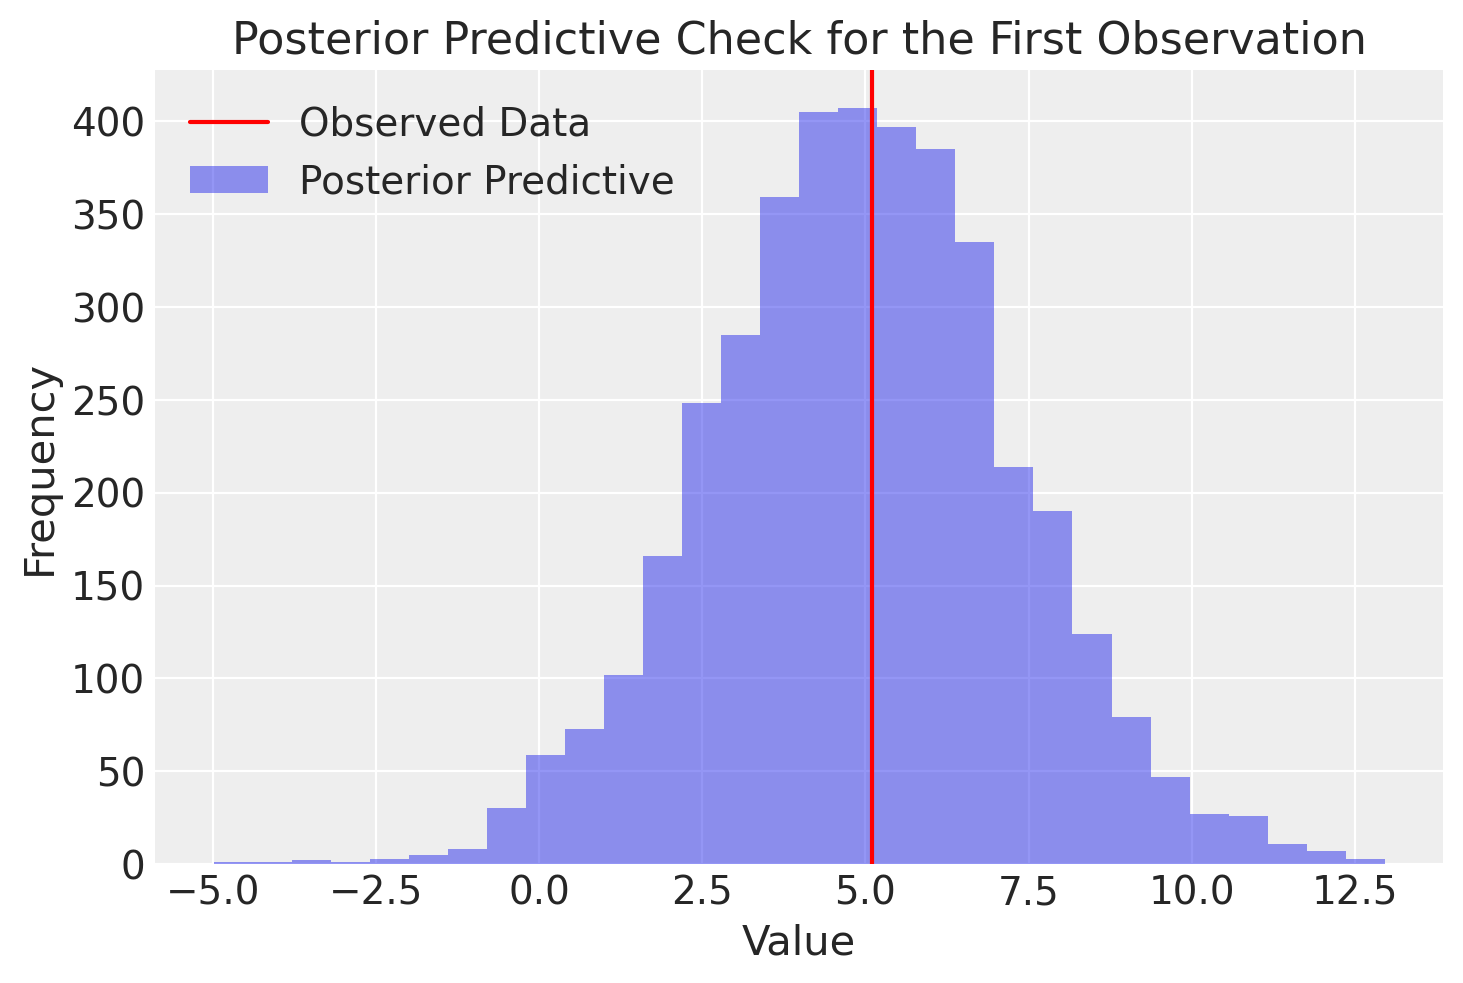

In [18]:
post_pred = ppc.posterior_predictive
y_i_post_pred = post_pred["y"].values[:, :, 0]

plt.hist(y_i_post_pred.flatten(), bins=30, alpha=0.5)
plt.axvline(data[0], color="r")
plt.title("Posterior Predictive Check for the First Observation")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend(["Observed Data", "Posterior Predictive"])
plt.show()

Per calcolare il logaritmo della densità predittiva per la prima osservazione, valutiamo la PDF per questa osservazione utilizzando ogni coppia di parametri $\mu$ e $\sigma$ dalla distribuzione posteriore. 

Selezione della prima osservazione:

In [6]:
y_i = data[0]
y_i

5.177786137727856

Estrazione dei parametri dal campione posteriore:

In [7]:
mu_samples = trace.posterior["mu"].values.flatten()
mu_samples[0:10]

array([5.11569411, 4.83003157, 5.14970101, 4.83143653, 4.91616599,
       5.01748009, 4.90922124, 4.73683245, 4.96708977, 4.56084336])

In [8]:
sigma_samples = trace.posterior["sigma"].values.flatten()
sigma_samples[0:10]

array([1.84899899, 1.9980007 , 1.87757895, 2.03453738, 1.69487256,
       2.18976109, 1.87648886, 1.83853294, 1.96770967, 2.07094644])

Calcolo della densità di probabilità per ogni coppia di parametri:

In [9]:
pdf_values = [
    stats.norm.pdf(y_i, mu, sigma) for mu, sigma in zip(mu_samples, sigma_samples)
]

pdf_values[0:5]

[0.2156395979558876,
 0.19666913409171222,
 0.21245319820910058,
 0.19326422523669046,
 0.23259429780060442]

Calcolo del logaritmo delle densità:

In [10]:
log_pdf_values = np.log(pdf_values)
log_pdf_values[0:5]

array([-1.53414679, -1.62623248, -1.54903356, -1.64369698, -1.45845955])

Calcolo della media dei valori logaritmici:

In [11]:
mean_log_density = np.mean(log_pdf_values)
mean_log_density

-1.5894776737925367

Questo calcolo ci fornisce una stima empirica della media della densità logaritmica predittiva (ELPD) per la prima osservazione del campione.

#### Tutte le Osservazioni del Campione

Per calcolare la media della densità logaritmica predittiva (ELPD) per tutte le osservazioni nel  campione, è necessario seguire un processo simile a quello usato per una singola osservazione, ma esteso a tutte le osservazioni nel set di dati. Il processo consiste nel calcolare la densità logaritmica predittiva per ciascuna osservazione, come visto in precedenza, e poi fare la media su tutte queste densità.

In [19]:
# Calcolo della densità logaritmica predittiva per ogni osservazione
all_log_densities = []
for y_i in data:
    pdf_values = [
        stats.norm.pdf(y_i, mu, sigma) for mu, sigma in zip(mu_samples, sigma_samples)
    ]
    log_pdf_values = np.log(pdf_values)
    mean_log_density = np.mean(log_pdf_values)
    all_log_densities.append(mean_log_density)

In [20]:
# Calcolo della media su tutte le osservazioni
overall_mean_log_density = np.mean(all_log_densities)
overall_mean_log_density

-2.2860581863143365

## Leave One Out Cross-Validation (LOO-CV) 

In termini pratici, per la stima dell'Expected Log Predictive Density (ELPD), l'approccio più comune non si basa sulla media della densità logaritmica predittiva calcolata direttamente. Piuttosto, si preferisce utilizzare un metodo di validazione incrociata più robusto, noto come Leave One Out Cross-Validation (LOO-CV). Questa procedura si articola in diverse fasi:

1. Rimozione di un'osservazione dal set di dati.
2. Adattamento del modello ai dati restanti.
3. Valutazione della predizione per l'osservazione esclusa.
4. Ripetizione del processo per ciascuna osservazione nel dataset, calcolando la media dei valori logaritmici predittivi per arrivare alla stima LOO-CV dell'ELPD.

Sia la media della LPD che la LOO-CV si focalizzano sulla valutazione della capacità predittiva di un modello, ma differiscono nel loro approccio:

- **Media della LPD**: Questa misura valuta la capacità predittiva del modello sull'intero dataset, basandosi sulla probabilità complessiva dei dati osservati secondo il modello.

- **LOO-CV**: Invece, la LOO-CV offre una valutazione più robusta e generalizzabile della capacità predittiva, eliminando una osservazione per volta dal dataset. Questo metodo è particolarmente vantaggioso per valutare la capacità di generalizzazione del modello oltre i dati su cui è stato addestrato, fornendo una stima più realistica della sua efficacia nel predire nuovi dati.

Esaminiamo il calcolo di LOO-CV per i dati dell'esempio precedente. Iniziamo a calcolare la log-verosimiglianza.

In [27]:
with model:
    pm.compute_log_likelihood(trace)

Ora usiamo la funzione `loo()` del pacchetto Arviz per calcolare LOO-CV:

In [28]:
loo_result = az.loo(trace, pointwise=True)
print(loo_result)

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -226.64     8.75
p_loo        2.44        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Si noti che il valore assoluto di `overall_mean_log_density` (-2.286) non è direttamente confrontabile con il valore di `elpd_loo` (-226.64) a causa delle differenze nella loro scala e nel modo in cui vengono calcolati. Mentre `overall_mean_log_density` è la media del logaritmo delle densità per ogni osservazione, `elpd_loo` è una stima complessiva dell'adattamento del modello che tiene conto della validazione incrociata e della capacità predittiva. Tuttavia, in entrambi i casi, valori più alti indicano prestazioni migliori.

In conclusione, mentre la media della LPD fornisce una valutazione della performance del modello basata sull'intero set di dati, la LOO-CV offre una prospettiva più rigorosa e generalizzabile sulla capacità predittiva del modello. È importante notare che strumenti come PyMC e Arviz facilitano il calcolo della LOO-CV, specialmente in scenari che coinvolgono l'utilizzo di tecniche di campionamento MCMC. Questi strumenti possono semplificare notevolmente l'analisi in contesti di statistica bayesiana.

### Valori Diagnostici Pareto $k$

Per stabilire quanto sia affidabile l'approssimazione effettuata attraverso LOO-CV si ricorre a un parametro diagnostico noto come valore Pareto $ k $. Nel contesto della validazione incrociata di tipo Leave-One-Out (LOO), il valore Pareto $ k $ serve come un barometro per giudicare la precisione dell'approssimazione LOO. Il valore di $ k $ funge da indicatore della qualità dell'approssimazione e ha le seguenti interpretazioni:

- **$ k < 0.5 $**: In questo caso, l'approssimazione è generalmente ottima e l'errore associato è trascurabile.
  
- **$ 0.5 \leq k < 0.7 $**: L'approssimazione rimane buona, sebbene con qualche motivo di cautela. Un'analisi più approfondita del modello e dei dati potrebbe essere vantaggiosa.

- **$ 0.7 \leq k < 1 $**: La qualità dell'approssimazione è mediocre. I risultati derivanti da LOO possono essere poco affidabili; potrebbe quindi essere utile considerare metodi di validazione alternativi o apportare modifiche al modello.

- **$ k \geq 1 $**: Qui, l'approssimazione è inadeguata e i risultati da LOO sono molto probabilmente inaffidabili. Questo è un campanello d'allarme che indica potenziali problemi con il modello o con il metodo di approssimazione adottato.

Il valore diagnostico Pareto $ k $ è basato sulla distribuzione di Pareto e serve a valutare in che misura le code della distribuzione delle differenze di log-verosimiglianza (tra la log-verosimiglianza del punto dati escluso e quella relativa all'intero set di dati) divergono da una distribuzione esponenziale. Un valore di $ k $ elevato suggerisce che le code della distribuzione sono più pesanti del previsto, indicando che l'approssimazione LOO-CV potrebbe essere imprecisa.

In sintesi, il valore Pareto $ k $ offre uno strumento pratico per verificare l'affidabilità dell'approssimazione LOO-CV. Permette inoltre ai ricercatori di identificare e indagare su potenziali problematiche relative sia al modello che alla metodologia di validazione incrociata adottata. 

Come abbiamo visto nell'esempio precedente, i valori diagnostici Pareto $k$ sono stampati dalla funzione `loo()` del pacchetto Arviz.

### Ruolo dell'ELPD nella Valutazione Comparativa dei Modelli

L'ELPD è una metrica essenziale per effettuare confronti tra vari modelli statistici. Ottenendo una stima dell'ELPD attraverso metodologie come la Validazione Incrociata Leave-One-Out (LOO-CV), si può acquisire una valutazione obiettiva dell'adeguatezza di ciascun modello rispetto ai dati a disposizione. Questo aspetto assume particolare importanza quando si è chiamati a selezionare il modello più idoneo tra diverse alternative, o quando si desidera determinare se un modello di maggiore complessità offra un migliore adattamento rispetto a uno più semplice.

In sintesi, l'ELPD funge da indicatore affidabile della capacità predittiva di un modello. Allo stesso tempo, la tecnica del LOO-CV fornisce un mezzo efficace per approssimare tale metrica. Grazie alla LOO-CV, gli analisti possono condurre una valutazione sia accurata che robusta delle prestazioni di differenti modelli, agevolando la decisione relativa al modello più appropriato per uno specifico contesto.

L'opportunità di automatizzare queste procedure di valutazione attraverso l'uso di librerie software come PyMC e Arviz rende l'intero approccio ancor più accessibile e pratico, consolidando la sua utilità come strumento per l'accurata selezione e validazione di modelli statistici. 

### Simulazione

Per illustrare questa metodologia di confronto tra modelli utilizzando la LOO-CV, procediamo con una simulazione. Genereremo dati sintetici in cui esiste una relazione lineare tra le variabili $x$ e $y$. In questo scenario, potremmo essere interessati a confrontare un modello lineare con un modello più semplice, che considera solo il termine di intercetta. Utilizzeremo la LOO-CV per stabilire quale dei due modelli si adatta meglio ai dati in questione. La stima dell'ELPD servirà come criterio quantitativo per orientare questa scelta di modello.

In [16]:
# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100)
y_true = 3 + 2 * X
y_obs = y_true + np.random.normal(scale=3, size=100)

Adattiamo ai dati un modello che rispecchia il vero meccanismo generativo dei dati.

Si noti che, per calcolare LOO e WAIC, ArviZ ha bisogno di accedere alla log-likelihood per ogni campione posteriore. Possiamo trovarla tramite `compute_log_likelihood()`. In alternativa, possiamo passare `idata_kwargs={"log_likelihood": True}` a `sample()` per farla calcolare automaticamente alla fine del campionamento.

In [17]:
# Linear model
with pm.Model() as linear_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    mu = alpha + beta * X
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

In [18]:
with linear_model:
    linear_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time = 0:00:16.614344
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1156.58it/s]
Sampling time = 0:00:02.216347
Transforming variables...
Transformation time = 0:00:00.071351
Computing Log Likelihood...
Log Likelihood time = 0:00:01.232768


Adattiamo ora un secondo modello che non tiene conto della relazione lineare tra x e y.

In [19]:
# Intercept model
with pm.Model() as intercept_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    mu = alpha 
    y = pm.Normal("y", mu=mu, observed=y_obs)

In [20]:
with intercept_model:
    intercept_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time = 0:00:01.453723
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1760.65it/s]
Sampling time = 0:00:01.192157
Transforming variables...
Transformation time = 0:00:00.029271
Computing Log Likelihood...
Log Likelihood time = 0:00:00.067155


Troviamo ora elpd con il metodo LOO.

In [21]:
linear_loo = az.loo(linear_trace)
linear_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -244.51     6.90
p_loo        2.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [22]:
intercept_loo = az.loo(intercept_trace)
intercept_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2253.26   196.00
p_loo       44.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Infine, calcoliamo `eldp_diff`. L'incertezza di questa quantità è espressa dall'errore standard. Se il rapporto tra `eldp_diff` e il suo errore standard è almeno uguale a 2, allora possiamo concludere che vi è una differenza credibile tra di due modelli.

In [23]:
df_comp_loo = az.compare({"linear_model": linear_trace, "intercept_model": intercept_trace})
df_comp_loo

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear_model,0,-244.514284,2.804516,0.000000,1.0,6.898951,0.000000,False,log
intercept_model,1,-2253.259435,44.940368,2008.745151,0.0,196.002578,195.676445,False,log


Nel caso presente, sappiamo che il modello che include una relazione lineare tra le due variabili è quello che rispecchia il modo in cui i dati sono stati generati. Infatti, troviamo che il rapporto tra `eldp_diff` e il suo errore standard è molto maggiore di 2, il che conferma che, per questi dati, il modello lineare è da preferire al modello che include solo l'intercetta.

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


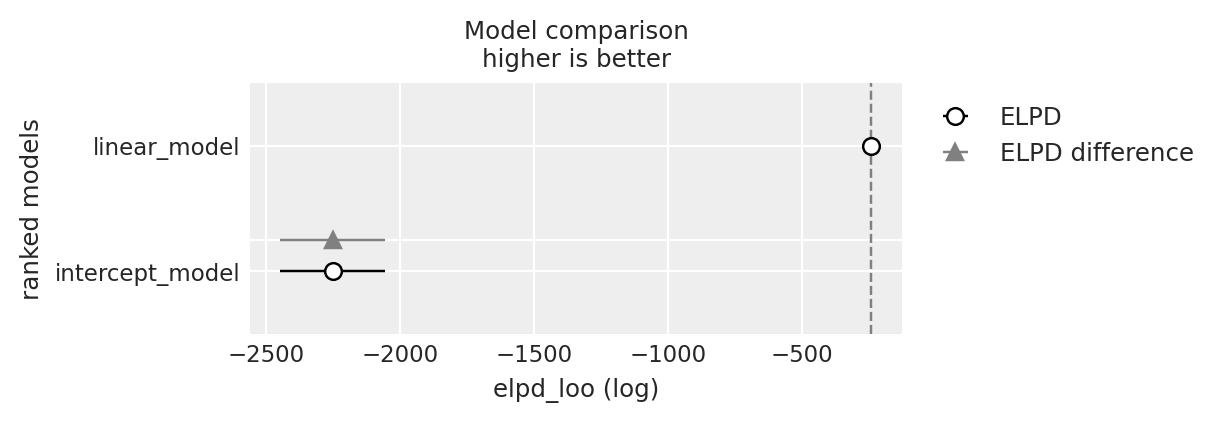

In [24]:
az.plot_compare(df_comp_loo, insample_dev=False);

## Commenti e Considerazioni Finali 

Nel corso di questo capitolo, abbiamo esplorato in profondità il concetto della Densità Logaritmica Predittiva Prevista (ELPD), una metrica fondamentale nell'ambito dell'analisi statistica bayesiana. L'ELPD si distingue non solo come strumento per valutare le prestazioni di un modello statistico, ma assume un ruolo cruciale nel confronto tra diversi modelli.

L'adozione dell'ELPD come criterio di confronto offre una prospettiva oggettiva e basata sui dati per determinare quale modello sia più aderente e rappresentativo rispetto alle informazioni a nostra disposizione. In un panorama scientifico e applicativo di crescente complessità, dove le alternative di modellazione si moltiplicano e divergono, l'ELPD emerge come un faro guida per orientare la scelta verso il modello più appropriato. Questa metrica si rivela particolarmente utile sia nel confronto tra modelli di diversa complessità, sia nella selezione tra vari approcci modellistici, fornendo una valutazione quantitativa e imparziale della loro capacità predittiva.

In sintesi, l'ELPD rappresenta uno strumento imprescindibile nell'arsenale dell'analista dei dati moderno. Il suo impiego in fase di scelta e valutazione dei modelli contribuisce in modo significativo a chiarire e guidare le decisioni analitiche, portando a risultati più robusti e modelli statistici maggiormente efficaci. In definitiva, l'ELPD non solo facilita la comprensione delle performance dei modelli, ma promuove anche una maggiore fiducia nelle previsioni che essi generano, un aspetto fondamentale in qualsiasi campo di applicazione statistica.

## Watermark

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Sep 05 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

seaborn    : 0.12.2
statsmodels: 0.14.0
numpy      : 1.25.2
scipy      : 1.11.2
matplotlib : 3.7.2
arviz      : 0.16.1
pymc       : 5.7.2
pandas     : 2.1.0

Watermark: 2.4.3

